Bayu Kurniawan
21/480093/GE/09662

IMPORT LIBRARY 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.nn.modules.loss import BCEWithLogitsLoss, BCELoss
import rasterio
import numpy as np
import matplotlib
import os
import glob
import shutil
import matplotlib.pyplot as plt
import cv2
from IPython.core.pylabtools import figsize
from Model.load_data import CustomGeoDataset
from Model.unet import unet

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("[INFO] training using {} ...".format(DEVICE))

[INFO] training using cuda ...


INISIASI LOKASI DARI DATASET (LABEL DAN GAMBAR) SERTA DATA HASIL AUGMENTASI

In [4]:
Image_Drive = "./Data/image3"
Label_Drive = "./Data/label3"

#augmented data
Image_aug = "./Data/Transformed_images"
Label_aug = "./Data/Transformed_labels"

image_path = glob.glob(os.path.join(Image_Drive, "*.tif"))
label_path = glob.glob(os.path.join(Label_Drive, "*.tif"))

image_size = len(image_path)
label_size = len(label_path)

print(image_size)
print(label_size)

1086
1086


In [5]:
aug_image_path = glob.glob(os.path.join(Image_aug, "*.tif"))
aug_label_path = glob.glob(os.path.join(Label_aug, "*.tif"))

image_path = image_path + aug_image_path
label_path = label_path + aug_label_path

image_size = len(image_path)
label_size = len(label_path)

print(image_size)
print(label_size)


2172
2172


In [6]:
# Instantiate the custom dataset with transformations
train_data = CustomGeoDataset(image_path, label_path)
print(len(train_data))

split_size = 0.80
train_size = int(split_size * len(train_data))
test_size = len(train_data) - train_size
train_data, test_data = torch.utils.data.random_split(train_data, [train_size, test_size])

#dataloader
trainloader = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size=32)
testloader = torch.utils.data.DataLoader(test_data, shuffle = True, batch_size=32)

print(len(trainloader))
print(len(testloader))

2172
55
14


MENGINISIASI TRAIN STEP YANG BERISI TERKAIT PREDIKSI, MODE TRAINING, DAN PERHITUNGAN LOSS

In [7]:
def make_train_step(model, optimizer, loss_fn):
    def train_step(x, y):
        # Ensure x has the correct shape
        if x.dim() == 3:
            x = x.unsqueeze(1)  # Add channel dimension
        
        # Make prediction
        yhat = model(x)
        # Enter train mode
        model.train()
        # Compute loss
        loss = loss_fn(yhat, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        return loss
    return train_step

MENGIMPORT MODEL UNET YANG AKAN DITRAIN

In [8]:
from Model.unet import unet

modelunet = unet(inchannels=1)
print(modelunet)
modelunet = modelunet.to(DEVICE)

unet(
  (conv_block1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_block11): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_block22): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )

PENENTUAN PARAMTER TRAINING SEPERTI EPOCH, OPTIMIZER, LOSS FUNCTION, DAN TRAIN STEP YANG DIBUAT SEBELUMNYA

In [11]:
from torch.optim import Adam

# define training hyperparameters
INIT_LR = 1e-4
epochs = 25

# initialize our optimizer and loss function
optimizer = Adam(modelunet.parameters(), lr=INIT_LR)
lossfn = BCEWithLogitsLoss()

#train step
train_step = make_train_step(modelunet, optimizer, lossfn)
print(train_step)

<function make_train_step.<locals>.train_step at 0x0000016FBF034AE0>


MEMBUAT FUNCTION UNTUK TRAIN DAN EVALUASI MODEL YANG AKAN DIGUNAKAN NANTINYA

In [14]:
from tqdm import tqdm
from torchmetrics import JaccardIndex

def train(model, trainloader, optimizer, loss_fn, device):
    model.train()
    train_step = make_train_step(model, optimizer, loss_fn)
    epoch_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    jaccard = JaccardIndex(task='binary').to(DEVICE)

    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        x_batch, y_batch = data
        x_batch = x_batch.float().to(device)  # Ensure correct type
        y_batch = y_batch.float().to(device)

        # Forward pass and loss calculation
        loss = train_step(x_batch, y_batch)
        epoch_loss += loss.item()

        # Predictions untuk binary, untuk multi-class: loss function: CE, activation: softmax, classification: argmax, binary Loss fun: BCE, activation: sigmoid, classfication: threshold
        predictions = (model(x_batch) > 0.5).float()  # Binary thresholding at 0.5

        # Accuracy calculation
        correct_predictions += torch.sum(predictions == y_batch).item()
        total_predictions += (y_batch.size(0) * y_batch.size(1) * y_batch.size(2) * y_batch.size(3))

        # jaccard index (IoU) calculation
        jaccard.update(predictions, y_batch)

    accuracy = (correct_predictions/total_predictions) * 100  # Convert to percentage
    average_loss = epoch_loss / len(trainloader)
    iou = jaccard.compute()

    return average_loss, accuracy, iou

def evaluate(model, testloader, loss_fn, device):
    model.eval()
    epoch_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    jaccard = JaccardIndex(task='binary').to(DEVICE)

    with torch.no_grad():
        for x_batch, y_batch in testloader:
            x_batch = x_batch.float().to(device)
            y_batch = y_batch.float().to(device)

            # Forward pass and loss calculation
            yhat = model(x_batch)
            loss = loss_fn(yhat, y_batch)
            epoch_loss += loss.item()

            # Predictions
            predicted_classes = (yhat > 0.5).float() # Round to get binary predictions
            correct_predictions += torch.sum(predicted_classes == y_batch).item()
            total_predictions += (y_batch.size(0) * y_batch.size(1) * y_batch.size(2) * y_batch.size(3))

            #jaccard calculation
            jaccard.update(predicted_classes, y_batch)

    accuracy = (correct_predictions / total_predictions) * 100  # Convert to percentage
    average_loss = epoch_loss / len(testloader)
    iou = jaccard.compute()

    return average_loss, accuracy, iou


MELAKUKAN TRAINING DARI PARAMETER DAN FUNCTION YANG TELAH DIBUAT SEBELUMNYA

In [15]:
best_loss = float('inf')
best_model_wts = None

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
train_ious = []
test_ious = []

for epoch in range(epochs):
    train_loss, train_accuracy, train_iou = train(modelunet, trainloader, optimizer, lossfn, DEVICE)
    test_loss, test_accuracy, test_iou = evaluate(modelunet, testloader, lossfn, DEVICE)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    train_ious.append(train_iou)
    test_ious.append(test_iou)

    print(f'Epoch {epoch + 1}/{epochs}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train IOU: {train_iou:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test IOU: {test_iou:.4f}')

    # Save the best model
    if test_loss < best_loss:
        best_loss = test_loss
        best_model_wts = modelunet.state_dict()

modelunet.load_state_dict(best_model_wts)


  0%|          | 0/55 [00:00<?, ?it/s]c:\Users\ASUS\anaconda3\Lib\site-packages\rasterio\__init__.py:317: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
100%|██████████| 55/55 [01:06<00:00,  1.21s/it]


Epoch 1/25: Train Loss: 0.2918, Train Accuracy: 93.6848, Train IOU: 0.0000, Test Loss: 0.1473, Test Accuracy: 94.1581, Test IOU: 0.0000


100%|██████████| 55/55 [01:04<00:00,  1.17s/it]


Epoch 2/25: Train Loss: 0.1491, Train Accuracy: 93.7787, Train IOU: 0.0248, Test Loss: 0.1337, Test Accuracy: 94.2805, Test IOU: 0.0738


100%|██████████| 55/55 [01:04<00:00,  1.17s/it]


Epoch 3/25: Train Loss: 0.1458, Train Accuracy: 95.1971, Train IOU: 0.2821, Test Loss: 0.1123, Test Accuracy: 96.1385, Test IOU: 0.3982


100%|██████████| 55/55 [01:04<00:00,  1.17s/it]


Epoch 4/25: Train Loss: 0.1221, Train Accuracy: 96.0628, Train IOU: 0.4220, Test Loss: 0.1028, Test Accuracy: 96.6004, Test IOU: 0.4442


100%|██████████| 55/55 [01:08<00:00,  1.24s/it]


Epoch 5/25: Train Loss: 0.1045, Train Accuracy: 96.7479, Train IOU: 0.5169, Test Loss: 0.0938, Test Accuracy: 97.0484, Test IOU: 0.5177


100%|██████████| 55/55 [01:10<00:00,  1.28s/it]


Epoch 6/25: Train Loss: 0.1067, Train Accuracy: 96.7718, Train IOU: 0.5186, Test Loss: 0.1512, Test Accuracy: 97.3075, Test IOU: 0.5782


100%|██████████| 55/55 [01:04<00:00,  1.18s/it]


Epoch 7/25: Train Loss: 0.1018, Train Accuracy: 96.7902, Train IOU: 0.5248, Test Loss: 0.0954, Test Accuracy: 96.7768, Test IOU: 0.4655


100%|██████████| 55/55 [01:04<00:00,  1.18s/it]


Epoch 8/25: Train Loss: 0.0967, Train Accuracy: 97.0200, Train IOU: 0.5511, Test Loss: 0.0905, Test Accuracy: 96.9817, Test IOU: 0.4983


100%|██████████| 55/55 [01:04<00:00,  1.18s/it]


Epoch 9/25: Train Loss: 0.0960, Train Accuracy: 97.0454, Train IOU: 0.5568, Test Loss: 0.0845, Test Accuracy: 97.2527, Test IOU: 0.5449


100%|██████████| 55/55 [01:05<00:00,  1.18s/it]


Epoch 10/25: Train Loss: 0.0931, Train Accuracy: 97.1492, Train IOU: 0.5684, Test Loss: 0.0838, Test Accuracy: 97.3492, Test IOU: 0.5626


100%|██████████| 55/55 [01:04<00:00,  1.18s/it]


Epoch 11/25: Train Loss: 0.0899, Train Accuracy: 97.2677, Train IOU: 0.5859, Test Loss: 0.0854, Test Accuracy: 97.4255, Test IOU: 0.5772


100%|██████████| 55/55 [01:04<00:00,  1.17s/it]


Epoch 12/25: Train Loss: 0.0890, Train Accuracy: 97.3499, Train IOU: 0.5977, Test Loss: 0.0849, Test Accuracy: 97.1007, Test IOU: 0.5179


100%|██████████| 55/55 [01:04<00:00,  1.17s/it]


Epoch 13/25: Train Loss: 0.0885, Train Accuracy: 97.2826, Train IOU: 0.5862, Test Loss: 0.0817, Test Accuracy: 97.4454, Test IOU: 0.5733


100%|██████████| 55/55 [01:04<00:00,  1.17s/it]


Epoch 14/25: Train Loss: 0.0895, Train Accuracy: 97.3506, Train IOU: 0.5979, Test Loss: 0.0831, Test Accuracy: 97.4664, Test IOU: 0.5825


100%|██████████| 55/55 [01:04<00:00,  1.17s/it]


Epoch 15/25: Train Loss: 0.0850, Train Accuracy: 97.4096, Train IOU: 0.6048, Test Loss: 0.0789, Test Accuracy: 97.4980, Test IOU: 0.5843


100%|██████████| 55/55 [01:04<00:00,  1.17s/it]


Epoch 16/25: Train Loss: 0.0894, Train Accuracy: 97.4755, Train IOU: 0.6148, Test Loss: 0.0893, Test Accuracy: 96.9655, Test IOU: 0.4882


100%|██████████| 55/55 [01:04<00:00,  1.17s/it]


Epoch 17/25: Train Loss: 0.1098, Train Accuracy: 96.7461, Train IOU: 0.5091, Test Loss: 0.0887, Test Accuracy: 97.1688, Test IOU: 0.5386


100%|██████████| 55/55 [01:04<00:00,  1.18s/it]


Epoch 18/25: Train Loss: 0.0926, Train Accuracy: 97.2779, Train IOU: 0.5865, Test Loss: 0.0892, Test Accuracy: 97.1334, Test IOU: 0.5184


100%|██████████| 55/55 [01:04<00:00,  1.18s/it]


Epoch 19/25: Train Loss: 0.0932, Train Accuracy: 97.2387, Train IOU: 0.5842, Test Loss: 0.0802, Test Accuracy: 97.5069, Test IOU: 0.5845


100%|██████████| 55/55 [01:04<00:00,  1.17s/it]


Epoch 20/25: Train Loss: 0.0868, Train Accuracy: 97.4148, Train IOU: 0.6059, Test Loss: 0.0851, Test Accuracy: 97.4042, Test IOU: 0.5694


100%|██████████| 55/55 [01:04<00:00,  1.18s/it]


Epoch 21/25: Train Loss: 0.0883, Train Accuracy: 97.5117, Train IOU: 0.6199, Test Loss: 0.1126, Test Accuracy: 96.4936, Test IOU: 0.4460


100%|██████████| 55/55 [01:04<00:00,  1.17s/it]


Epoch 22/25: Train Loss: 0.0886, Train Accuracy: 97.3928, Train IOU: 0.6036, Test Loss: 0.0796, Test Accuracy: 97.3930, Test IOU: 0.5612


100%|██████████| 55/55 [01:04<00:00,  1.17s/it]


Epoch 23/25: Train Loss: 0.0815, Train Accuracy: 97.5954, Train IOU: 0.6315, Test Loss: 0.0829, Test Accuracy: 97.4634, Test IOU: 0.5733


100%|██████████| 55/55 [01:05<00:00,  1.19s/it]


Epoch 24/25: Train Loss: 0.0842, Train Accuracy: 97.5880, Train IOU: 0.6311, Test Loss: 0.1009, Test Accuracy: 96.7072, Test IOU: 0.4433


100%|██████████| 55/55 [01:04<00:00,  1.17s/it]


Epoch 25/25: Train Loss: 0.0852, Train Accuracy: 97.5634, Train IOU: 0.6276, Test Loss: 0.0834, Test Accuracy: 97.4287, Test IOU: 0.5784


<All keys matched successfully>

PLOTTING GRAFIK TRAIN VS VALIDATION IOU DAN TRAIN VS VALIDATION LOSS DARI HASIL TRAINING

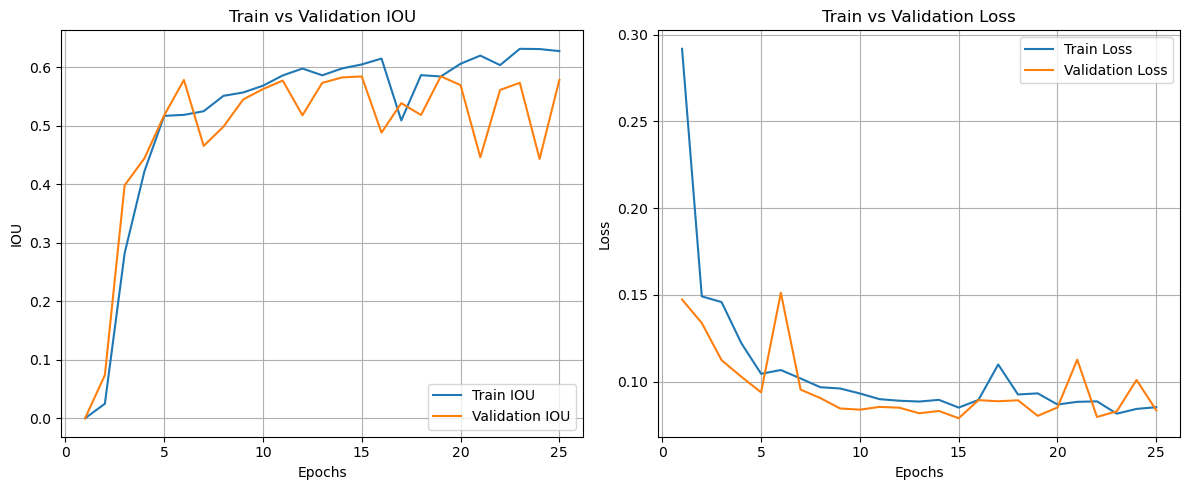

In [19]:
import matplotlib.pyplot as plt

# Function to convert GPU tensors to CPU tensors if needed
def to_cpu(tensor_list):
    return [tensor.cpu().numpy() if isinstance(tensor, torch.Tensor) else tensor for tensor in tensor_list]

# Convert tensors to CPU for plotting
train_ious_cpu = to_cpu(train_ious)
test_ious_cpu = to_cpu(test_ious)
train_losses_cpu = to_cpu(train_losses)
test_losses_cpu = to_cpu(test_losses)

# Plotting IOU
plt.figure(figsize=(12, 5))

# IOU Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_ious_cpu, label='Train IOU')
plt.plot(range(1, epochs+1), test_ious_cpu, label='Validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.title('Train vs Validation IOU')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_losses_cpu, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses_cpu, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


MENAMPILKAN/PLOT NILAI-NILAI AKURASI PADA SETIAP EPOCH DALAM BENTUK TABEL

In [20]:
import pandas as pd

# Data
epochs_list = list(range(1, epochs + 1))
train_accuracies_cpu = to_cpu(train_accuracies)
test_accuracies_cpu = to_cpu(test_accuracies)

# Create a DataFrame
df = pd.DataFrame({
    'Epoch': epochs_list,
    'Train Accuracy': train_accuracies_cpu,
    'Validation Accuracy': test_accuracies_cpu
})

# Display the DataFrame
print(df)

# If you want to display it in a more formatted way in Jupyter Notebook, you can use display from IPython
from IPython.display import display
display(df)

# To add the final test accuracy after training
final_test_accuracy = test_accuracies_cpu[-1]  # Assuming the last epoch's test accuracy is the final test accuracy
print(f'\nFinal Test Accuracy: {final_test_accuracy:.4f}')


    Epoch  Train Accuracy  Validation Accuracy
0       1       93.684776            94.158108
1       2       93.778655            94.280473
2       3       95.197085            96.138453
3       4       96.062786            96.600440
4       5       96.747905            97.048396
5       6       96.771820            97.307466
6       7       96.790232            96.776797
7       8       97.020016            96.981650
8       9       97.045449            97.252660
9      10       97.149180            97.349152
10     11       97.267747            97.425523
11     12       97.349901            97.100676
12     13       97.282576            97.445447
13     14       97.350642            97.466410
14     15       97.409629            97.497994
15     16       97.475460            96.965458
16     17       96.746109            97.168839
17     18       97.277895            97.133424
18     19       97.238660            97.506903
19     20       97.414801            97.404154
20     21    

,Epoch,Train Accuracy,Validation Accuracy
0,1,93.684776,94.158108
1,2,93.778655,94.280473
2,3,95.197085,96.138453
3,4,96.062786,96.600440
4,5,96.747905,97.048396
5,6,96.771820,97.307466
6,7,96.790232,96.776797
7,8,97.020016,96.981650
8,9,97.045449,97.252660
9,10,97.149180,97.349152



Final Test Accuracy: 97.4287


MENYIMPAN MODEL TRAINING DALAM FORMAT .PTH

In [16]:
torch.save(modelunet, 'modelunet.pth')
#load model
#modelunet = torch.load('modelunet.pth')


MELAKUKAN SPLITTING GAMBAR DARI CITRA

In [17]:
from Model.split_image import split

test_image = "./capella_testing_data.tif"
output_folder = "./Split"

split(test_image, 128, 32, output_folder)

list_split_image = glob.glob(os.path.join(output_folder, "*.tif"))



(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 128, 128)
(1, 12